http://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/

In [3]:
import numpy as np
import pymc
import scipy as sp

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Populating the interactive namespace from numpy and matplotlib


# The Order Dataset


| Experiment | Clicks | Orders | True Rate  | Empirical Rate |
|------------|--------|--------|------------|----------------|
|      A     | 1055   | 28     | 0.032      | 0.027          |
|      B     | 1057   | 45     | 0.041      | 0.043          |
|      C     | 1065   | 69     | 0.058      | 0.065          |
|      D     | 1039   | 58     | 0.047      | 0.056          |
|      E     | 1046   | 60     | 0.051      | 0.057          |

# Standard A/B Testing Model

In [5]:
values_A = np.hstack(([0]*(1055-28),[1]*28))
values_B = np.hstack(([0]*(1057-45),[1]*45))

In [10]:
from collections import Counter
print Counter(values_A)
print Counter(values_B)

Counter({0: 1027, 1: 28})
Counter({0: 1012, 1: 45})


In [11]:
#Create a uniform prior for the probabilities p_a and p_b
p_A = pymc.Uniform('p_A', 0, 1)
p_B = pymc.Uniform('p_B', 0, 1)

In [17]:
#Creates a posterior distribution of B - A
@pymc.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_B - p_A
obs_A = pymc.Bernoulli('obs_A', p_A, value = values_A , observed = True)
obs_B = pymc.Bernoulli('obs_B', p_B, value = values_B , observed = True)


model = pymc.Model([p_A, p_B, delta, values_A, values_B])
mcmc = pymc.MCMC(model)

mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 88.9 sec

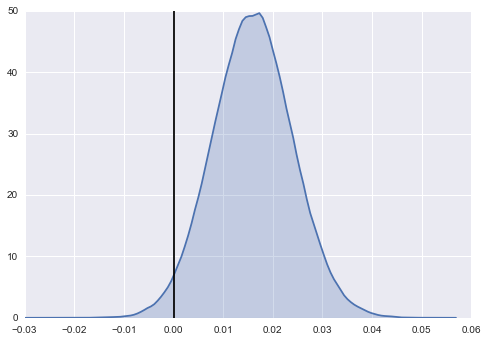

In [20]:
siteA_distribution = mcmc.trace("p_A")[:]
siteB_distribution = mcmc.trace("p_B")[:]
delta_distribution = mcmc.trace('delta')[:]

sns.kdeplot(delta_distribution, shade = True)
plt.axvline(0.00, color = 'black')

- The black line is at x = 0, representing where the difference between the two distributions is 0. From inspection, we see that most of the distribution's mass is to the right of the black line. This means most of the points sampled from B's distribution are larger than those sampled from A's distribution.



In [21]:
print "Probability that website A gets MORE sign-ups than website B: %0.3f" % (delta_distribution < 0).mean()
print "Probability that website A gets LESS sign-ups than website B: %0.3f" % (delta_distribution > 0).mean()

Probability that website A gets MORE sign-ups than website B: 0.022
Probability that website A gets LESS sign-ups than website B: 0.978


# Beta Distribution and Bayesian Priors

In [22]:
from scipy.stats import uniform,beta

In [23]:
support = np.linspace(0,1, 500)[1:-1]

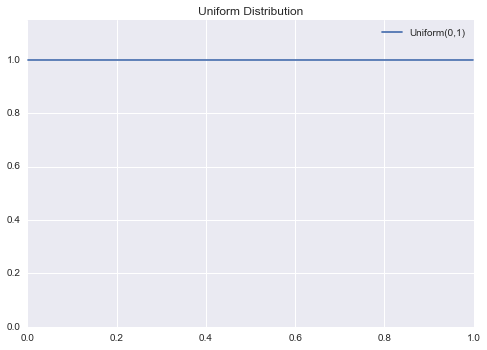

In [26]:
U_01 = uniform()
plt.plot(support, U_01.pdf(support), label = "Uniform(0,1)")
plt.ylim(0,1.15)
plt.legend()
plt.title("Uniform Distribution")

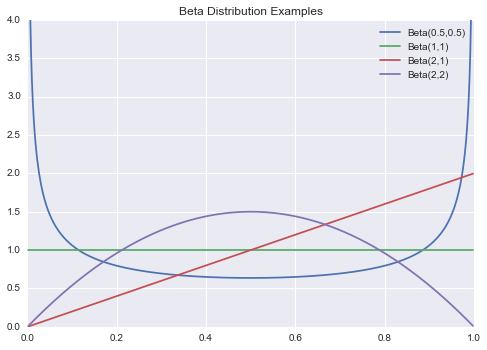

In [27]:
a_vals = [0.5, 1, 2, 2]
b_vals = [0.5, 1, 1, 2]
for a,b in zip(a_vals, b_vals):
    plt.plot(support, beta(a,b).pdf(support), label = "Beta(%s,%s)" %(a,b))
plt.legend()
plt.ylim(0,4)
plt.title("Beta Distribution Examples")

# Hierachical Models

In [28]:
@pymc.stochastic(dtype=np.float64)
def beta_priors(value=[1.0, 1.0]):
    a, b = value
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))

a = beta_priors[0]
b = beta_priors[1]

#The hidden, true rate for each website.
true_rates = pymc.Beta('true_rates', a, b, size=5)

# This is what we observed
trials = np.array([1055, 1057, 1065, 1039, 1046])
successes = np.array([28, 45, 69, 58, 60])
observed_values = pymc.Binomial('observed_values', trials, true_rates, observed=True, value=successes)

model = pymc.Model([a, b, true_rates, observed_values])
mcmc = pymc.MCMC(model)

# Generate 1M samples, and throw out the first 500k
mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 134.6 sec

- Now, the number of sign-ups, ki, is modeled by Binomial(ni,pi), and the true sign-up rate for each website, pi, is drawn from Beta(a,b). 
- The general idea behind this function is that it corporates ideas about the logit of the mean, log(a/b), and the log of the "sample size", log(a+b), to define a proper probability distribution for these two parameters. If the previous sentence means nothing to you, do not worry. All it is saying is that if we use this function, we get desired mathematical properties when sampling for a and b.

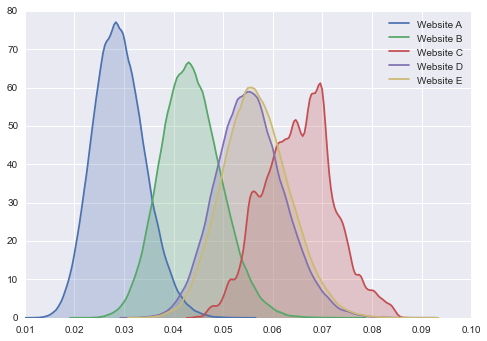

In [29]:
for i in range(5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "Website %s" % chr(65+i))
# plt.savefig("results/five_hier.png", format = "PNG")

- Now that we have all five posterior distributions, we can easily computer the difference between any two of them. In particular, let's look at the difference between Website C and Website A.

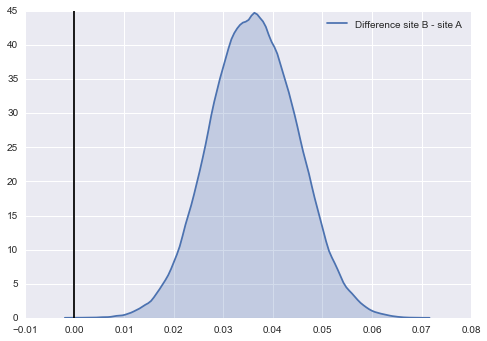

In [30]:
diff_CA = mcmc.trace('true_rates')[:][:,2] - mcmc.trace('true_rates')[:][:,0]  
sns.kdeplot(diff_CA, shade = True, label = "Difference site B - site A")
plt.axvline(0.0, color = 'black')
plt.savefig("results/hierarchial_BA.png", format = "PNG")

In [31]:
print "Probability that website A gets MORE sign-ups than website B: %0.3f" % (diff_CA < 0).mean()
print "Probability that website A gets LESS sign-ups than website B: %0.3f" % (diff_CA > 0).mean()

Probability that website A gets MORE sign-ups than website B: 0.000
Probability that website A gets LESS sign-ups than website B: 1.000


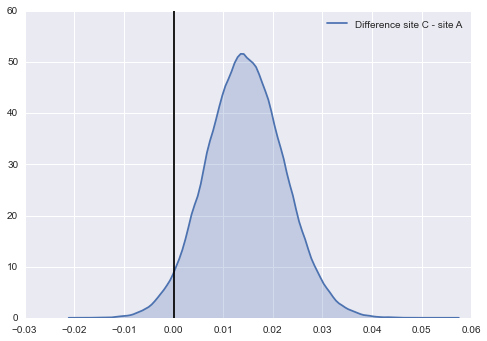

In [32]:
diff_BA = mcmc.trace('true_rates')[:][:,1] - mcmc.trace('true_rates')[:][:,0]
sns.kdeplot(diff_BA, shade = True, label = "Difference site C - site A")
plt.axvline(0.0, color = 'black')
# plt.savefig("results/hierarchial_CA.png", format = "PNG")

In [33]:
print "Probability that website A gets MORE sign-ups than website C: %0.3f" % (diff_BA < 0).mean()
print "Probability that website A gets LESS sign-ups than website C: %0.3f" % (diff_BA > 0).mean()

Probability that website A gets MORE sign-ups than website C: 0.030
Probability that website A gets LESS sign-ups than website C: 0.970


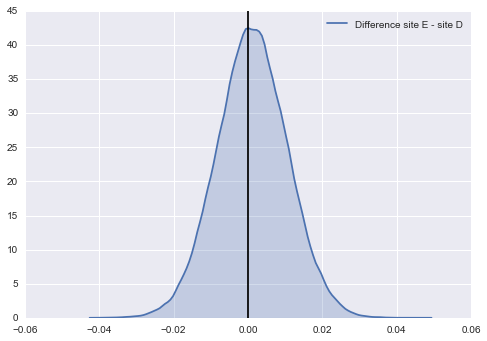

In [35]:
diff_ED = mcmc.trace('true_rates')[:][:,4] - mcmc.trace('true_rates')[:][:,3]
sns.kdeplot(diff_ED, shade = True, label = "Difference site E - site D")
plt.axvline(0.0, color = 'black')
# plt.savefig("results/hierarchial_ED.png", format = "PNG")

In [36]:
print "Probability that website D gets MORE sign-ups than website E: %0.3f" % (diff_ED < 0).mean()
print "Probability that website D gets LESS sign-ups than website E: %0.3f" % (diff_ED > 0).mean()

Probability that website D gets MORE sign-ups than website E: 0.453
Probability that website D gets LESS sign-ups than website E: 0.547


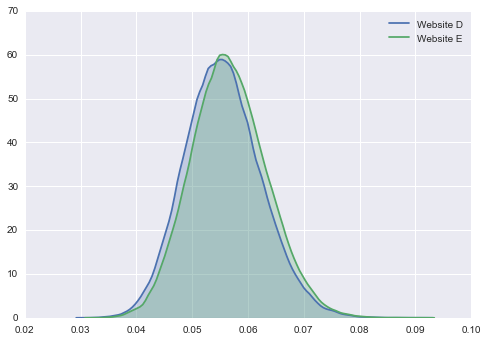

In [38]:
for i in range(3,5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "Website %s" % chr(65+i))
# plt.savefig("results/ED_dist.png", format = "PNG")

# Comparing the two methods

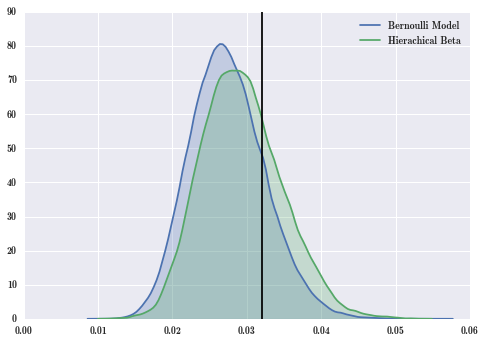

In [20]:
sns.kdeplot(siteA_distribution, shade = True, label = "Bernoulli Model")
sns.kdeplot(mcmc.trace('true_rates')[:][:,0], shade = True, label = "Hierachical Beta")
plt.axvline(0.032, color = 'black')
plt.savefig("results/hierarchial_better.png", format = "PNG")

- As you can see, the mass of the Hierarchical Beta-Binomial model is closer to the true rate that that of the Bernoulli model. The posteriors of the hierarchical model gave us a closer estimate of the true rate in this case.
- Why does the Hierarchical Beta-Binomial model appear to be more accurate in estimating the true rate? Well this comes down to the prior distributions used in each method. In the classical Bernoulli method, we used the Uniform(0,1) as our prior distribution. As I mentioned earlier, this is an uninformative prior as it assigns equal weight to all possible probabilities. On the other hand, the Beta prior creates a distribution that puts some of the probability mass towards the "truth" and thus we see a more a bit accurate estimate for the posterior distribution. If we slightly altered the values a and b for Beta distribution, it's possible we could see no difference between the two posteriors.

- Lastly, I believe it's worthwhile to mention the most widely known approach to deal with multiple comparisons: The Bonferroni Correction. If you recall from your introductory statistics course, the standard statistical inference procedure revolved around rejected a null hypothesis (H0) if the likelihood of the observed data given the null hypothesis is too small. We quantified what "is too small" meant using an α (alpha) value to represent our threshold for statistical significance (i.e. α = 0.05). 
The Bonferroni correction states that if we are going to be testing n hypotheses, then we need to lower our threshold for statistical significance to α/n. For example, if we are planning to test at the α = 0.05 level and we will be testing 10 hypotheses, then the Bonferroni correction states we should test at the 0.05/10 = 0.005 level. This means instead of rejecting our null hypothesis when we get a p-value less than 0.05, we reject our null hypothesis when we observe a p-value less than 0.005. There are other procedures to correct for multiple comparisons depending on the statistical test involved.